# Log anomaly,security threat detection and predictive maintenance

### Table of Contents

* **[OVERVIEW](#OVERVIEW)**
    
* **[Data Exploration](#Data-Preparation)**  
    * [Identify the data issues](#Identify-the-data-issues)
        * [Checking for missing Values](#Checking-for-missing-Values)
        * [Checking Zero values](#Checking-0-values)
        * [Checking Unique Values](#Checking-Unique-Values)
        * [Check Deuplicate values](#Check-Deuplicate-values)
* **[Data visualziation](#Data-visualziation)**
    * [HTTP Methods Distribution](#HTTP-Methods-Distribution)
    * [Status Codes Distribution](#Status-Codes-Distribution)
    * [User Agent Distribution](#User-Agent-Distribution)
    * [Finding outliers](#Finding-outliers)
    * [Finding corelations of all data attributes](#Finding-corelations-of-all-data-attributes)
* **[Data Preparation](#Data-Preparation)**
    * [Data Cleaning](#Data-Cleaning)
        * [Handling Missing Values](#Handling-Missing-Values)
        * [Parsing Timestamps](#Parsing-Timestamps )
        * [Finding Error Counts](#Finding-Error-Counts)
        * [Handling Outliers](#Handling-Outliers)
* **[Data Analysis](#Data-Analysis)**  
    * [Visitor Analysis](#Visitor-Analysis)
        * [Unique Visitors](#Unique-Visitors)
    * [Behavior Analysis](#Behavior-Analysis)
        * [Popular Pages](#Popular-Pages)
        * [Referrer Analysis](#Referrer-Analysis)
        * [User behavior analysis](#User-behavior-analysis)
    * [Crawler Detection](#Crawler-Detection)
        * [Identify Crawlers](#Identify-Crawlers)
    * [Security Insights](#Security-Insights)
        * [Identify Suspicious Requests](#Identify-Suspicious-Requests)
        * [Unsuccessful Login Attempts](#Unsuccessful-Login-Attempts)   
    * [Business Insights](#Business-Insights)
        * [Product Views](#Product-Views)
* **[ML Use Cases](#ML-Use-Cases)**  
    * [Predictive Maintenance](#Predictive-Maintenance)
    * [Anomaly Detection](#Anomaly-Detection)
    * [Security Threat Detection](#Security-Threat-Detection) 
        * [Tokenization](#Tokenization)
        * [Keyword Extraction](#Keyword-Extraction)
        * [Frequency Analysis](#Frequency-Analysis)
        * [bag-of-words approach to vectorize the textual features](#bag-of-words-approach-to-vectorize-the-textual-features)
* **[Recommendations](#Recommendations)** 



# OVERVIEW

<p><a href='https://www.kaggle.com/datasets/eliasdabbas/web-server-access-logs/'>Web sever logs</a> contain information on any event that was registered/logged. This contains a lot of insights on website visitors, behavior, crawlers accessing the site, business insights, security issues, and more.</p>
<p>This is an exercise for trying to gain insights from the web server logs and address the following use cases.</p>

<p><b>Predictive Maintenance</b> <br/>
The use case revolves around predicting anomalies or increased errors in a web server based on the rolling error count.This predictive maintenance approach allows proactive identification of potential issues, enabling timely interventions to prevent or minimize downtime and improve the overall reliability and performance of the web server.</p>

<p><b>Anomaly Detection</b><br/>
The use case is anomaly detection in web server logs. Anomalies could represent unusual or potentially malicious activities, and detecting them is crucial for ensuring the security and optimal performance of the web server. The Isolation Forest algorithm is effective in identifying patterns that deviate from the norm, making it suitable for anomaly detection in various contexts, including web server log analysis</p>

<p><b>Security Threat Detection</b><br/>
Web server log security threat detection involves leveraging machine learning, such as RandomForestClassifier, to analyze IP addresses, request paths, and user agents, categorizing requests as normal or suspicious based on predefined patterns,enhancing overall system security</p>

In [13]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import missingno as msno # Library to visualize missing values
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from warnings import filterwarnings 
filterwarnings('ignore')

def parse_log_entry(entry):
    pattern = r'(?P<IP>\d+\.\d+\.\d+\.\d+) - - \[(?P<Timestamp>[^\]]+)\] "(?P<Method>[A-Z]+) (?P<Path>[^"]+) HTTP/1\.1" (?P<Status>\d+) (?P<Bytes>\d+) "(?P<Referrer>[^"]*)" "(?P<User_Agent>[^"]*)"'
    match = re.match(pattern, entry)
    return match.groupdict() if match else {}


# Data exploration
### Exclude the log data with certain pattern match

In [14]:
# Define excluded patterns
excluded_patterns = ['/image/', '.css', '.png', '.jpg', '.jpeg', '.mp3', '.js']

# Read the log file into a list of dictionaries, excluding lines with certain patterns
with open('data/access.log') as file:
    log_entries = [entry for entry in file.readlines() if not any(pattern in entry for pattern in excluded_patterns)]

# Convert the list of dictionaries to a DataFrame
log_data = [parse_log_entry(entry) for entry in log_entries]
log_df = pd.DataFrame(log_data)

# Display the resulting DataFrame
log_df.head()

,IP,Timestamp,Method,Path,Status,Bytes,Referrer,User_Agent
0,54.36.149.41,22/Jan/2019:03:56:14 +0330,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,91.99.72.15,22/Jan/2019:03:56:17 +0330,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
2,66.249.66.194,22/Jan/2019:03:56:18 +0330,GET,"/filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7%D8%...",200,34277,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
3,207.46.13.136,22/Jan/2019:03:56:18 +0330,GET,/product/10214,200,39677,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,178.253.33.51,22/Jan/2019:03:56:19 +0330,GET,/m/product/32574/62991/%D9%85%D8%A7%D8%B4%DB%8...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...


<div style="background-color: yellow; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Observation:</b> The web server log I used is from <a href='https://www.kaggle.com/datasets/eliasdabbas/web-server-access-logs/'>Kaggle</a>. Since it is a large file, I couldn't check it into GIT. Please refer to the file on that site.
</div>

## Identify the data issues
### Checking for missing Values

In [15]:
# Find missing values and print columns with missing values
missing_values = log_df.isna().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
IP            686
Timestamp     686
Method        686
Path          686
Status        686
Bytes         686
Referrer      686
User_Agent    686
dtype: int64


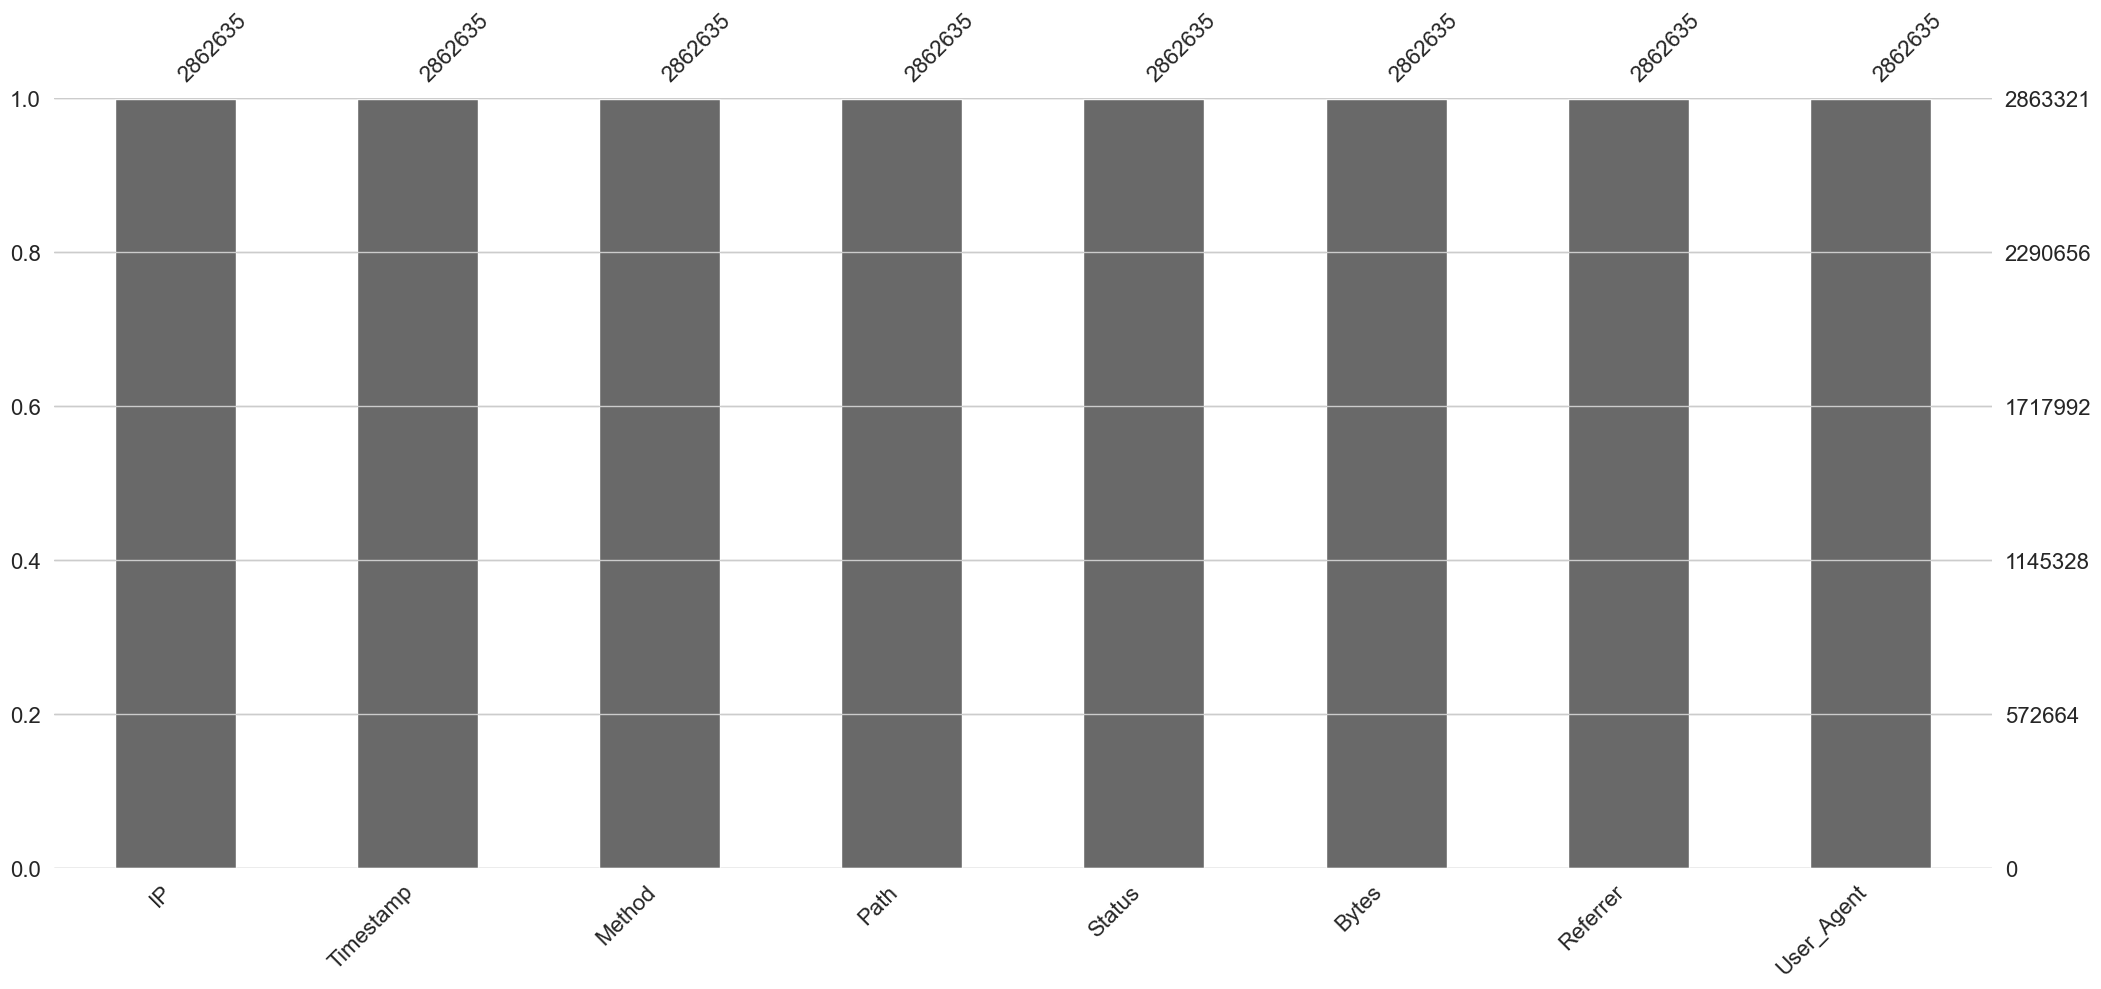

In [16]:
# Visualize the amount of missing values across the dataset features
msno.bar(log_df);

<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Observation:</b> From the chart above, it is evident that there are missing values
</div>

### Calculate the number of null values for each column

In [17]:
# Calculate the number of null values for each column
null_counts = log_df.isnull().sum()

# Calculate the percentage of null values for each column
null_percent = (null_counts / len(log_df)) * 100

# Combine the results into a DataFrame
null_df = pd.DataFrame({'Null Counts': null_counts, '% Null': null_percent}).sort_values(by='Null Counts', ascending=False)

print(null_df)


            Null Counts    % Null
IP                  686  0.023958
Timestamp           686  0.023958
Method              686  0.023958
Path                686  0.023958
Status              686  0.023958
Bytes               686  0.023958
Referrer            686  0.023958
User_Agent          686  0.023958


<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Observation:</b> It appears that some features have null values.
</div>

### Checking 0 values

In [18]:
log_df.eq(0).sum()

IP            0
Timestamp     0
Method        0
Path          0
Status        0
Bytes         0
Referrer      0
User_Agent    0
dtype: int64

<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Observation:</b> There are no 0 values.
</div>

### Checking Unique Values

In [19]:
# Assemble the unique counts with the data types and null counts for greater insight
unique_counts = log_df.nunique(axis=0)
dtypes = log_df.dtypes
null_percent = (log_df.isna().sum() / len(log_df)) * 100
unique_dtypes_df = pd.DataFrame({'Unique Values': unique_counts,'Dtype': 
                                 dtypes,'% Null': null_percent}).sort_values(by='Unique Values', 
                                                                             ascending=False)
unique_dtypes_df

,Unique Values,Dtype,% Null
Path,745272,object,0.023958
Timestamp,394007,object,0.023958
IP,140835,object,0.023958
Referrer,84809,object,0.023958
Bytes,55329,object,0.023958
User_Agent,18713,object,0.023958
Status,15,object,0.023958
Method,6,object,0.023958


<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Observation:</b> There seems to be a presence of categorical values, all falling under the 'object' data type. I'll need to conduct a closer examination of its values.
</div>

### Check Deuplicate values

In [20]:
# Check for duplicate rows
duplicate_rows = log_df.duplicated()

# Display duplicate rows
print("Duplicate Rows:")
print(log_df[duplicate_rows])


Duplicate Rows:
                    IP                   Timestamp Method  \
671                NaN                         NaN    NaN   
991      66.111.54.249  22/Jan/2019:04:02:23 +0330    GET   
1681       5.117.0.237  22/Jan/2019:04:07:15 +0330    GET   
2674               NaN                         NaN    NaN   
2677               NaN                         NaN    NaN   
...                ...                         ...    ...   
2863156   66.249.66.91  26/Jan/2019:20:28:53 +0330    GET   
2863167   66.249.66.91  26/Jan/2019:20:28:54 +0330    GET   
2863168   66.249.66.91  26/Jan/2019:20:28:54 +0330    GET   
2863176   66.249.66.91  26/Jan/2019:20:28:55 +0330    GET   
2863197   66.249.66.91  26/Jan/2019:20:28:57 +0330    GET   

                                                      Path Status Bytes  \
671                                                    NaN    NaN   NaN   
991      /m/product/27677/56223/%DB%8C%D8%AE%DA%86%D8%A...    499     0   
1681                      

# Data visualziation


### HTTP Methods Distribution

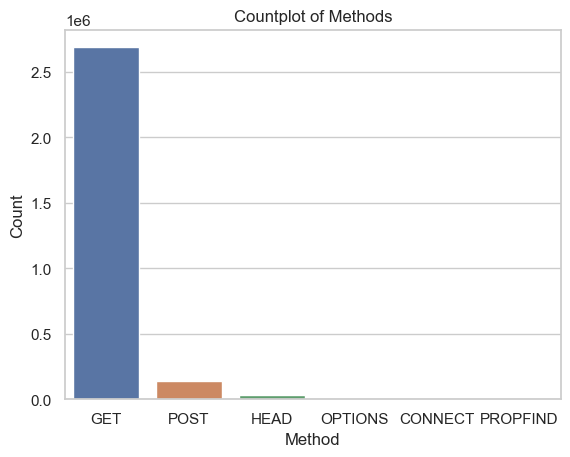

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Method' is a categorical column in log_df
sns.set(style="whitegrid")
sns.countplot(x='Method', data=log_df)

plt.title('Countplot of Methods')
plt.xlabel('Method')
plt.ylabel('Count')

# Save the countplot as an image file
plt.savefig('images/countplot_methods_seaborn.png')

# Show the plot
plt.show()


### Status Codes Distribution

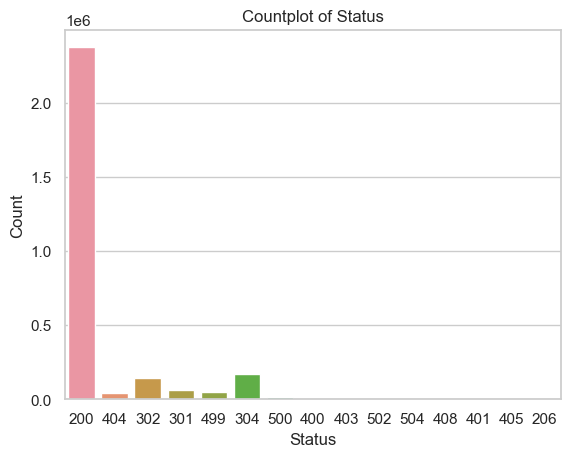

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Status' is a categorical column in log_df
sns.countplot(x='Status', data=log_df)
plt.title('Countplot of Status')
plt.xlabel('Status')
plt.ylabel('Count')

# Save the countplot as an image file
plt.savefig('images/countplot_status.png')

# Show the plot
plt.show()



### User Agent Distribution

<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Observation:</b> Most of the requests are success and there are some failures and need to analyze the failuers
</div>

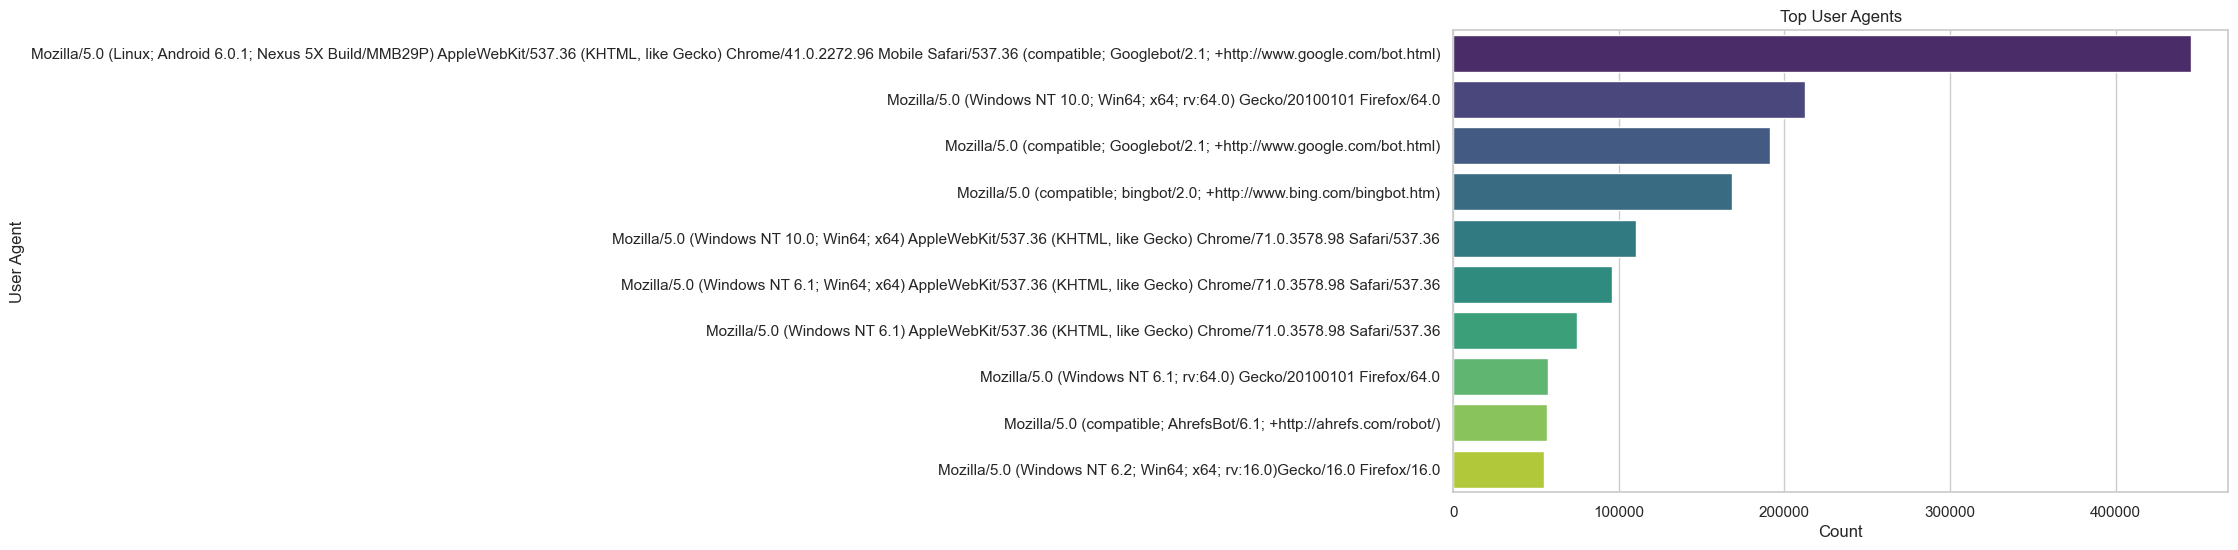

In [23]:
top_user_agents = log_df['User_Agent'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_user_agents.values, y=top_user_agents.index, palette='viridis')
plt.title('Top User Agents')
plt.xlabel('Count')
plt.ylabel('User Agent')

# Save the bar plot as an image file
plt.savefig('images/top_user_agents_barplot.png')

# Show the plot
plt.show()



## Finding outliers

In [24]:
# Iterate through each column
for column in log_df.columns:
    # Check if the column is of object type (categorical)
    if log_df[column].dtype == 'object':
        # Print the column name and its unique values
        print(f"Unique values for {column}:\n{log_df[column].unique()}\n")


Unique values for IP:
['54.36.149.41' '91.99.72.15' '66.249.66.194' ... '151.241.254.118'
 '5.213.7.50' '45.79.177.249']

Unique values for Timestamp:
['22/Jan/2019:03:56:14 +0330' '22/Jan/2019:03:56:17 +0330'
 '22/Jan/2019:03:56:18 +0330' ... '26/Jan/2019:20:29:11 +0330'
 '26/Jan/2019:20:29:12 +0330' '26/Jan/2019:20:29:13 +0330']

Unique values for Method:
['GET' 'POST' 'HEAD' nan 'OPTIONS' 'CONNECT' 'PROPFIND']

Unique values for Path:
['/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C%DA%A9%D8%B3%D9%84,27|%DA%A9%D9%85%D8%AA%D8%B1%20%D8%A7%D8%B2%205%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C%DA%A9%D8%B3%D9%84,p53'
 '/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%D8%B1-%D8%AE%D8%A7%D9%86%DA%AF%DB%8C-%D9%BE%D8%B1%D9%86%D8%B3%D9%84%DB%8C-%D9%85%D8%AF%D9%84-PR257AT'
 '/filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7%D8%B1%D9%BE%D8%B2,p56' ...
 '/filter/b583,b523' '/search/3500/null%2Cb245'
 '/product/29746/%D9%85%D8%A7%D8%B4%DB%8C%D9%86-%D8%A7%D8%B5%D9%84%D8%A7%D8%AD-%D8%A8%D8%AF%D9%86-%D9%BE%D8%B1%D9%86%D

In [25]:
# Sample log_df with a categorical column 'User_Agent'
log_df_user_agent = pd.DataFrame({'User_Agent': ['Chrome', 'Firefox', 'Chrome', 'Safari', 'Edge', 'Firefox', 'Opera', 'Chrome', 'Safari', 'Edge']})

# Set a threshold for the minimum count to consider a category as an outlier
threshold = 2

# Find outlier categories in the dataset
outlier_categories = log_df_user_agent['User_Agent'].value_counts()[log_df_user_agent['User_Agent'].value_counts() < threshold].index.tolist()

print("Outlier Categories:", outlier_categories)


Outlier Categories: ['Opera']


<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Observation:</b>the code identifies categories in the 'User_Agent' column that occur less than the specified threshold (in this case, 2 times).
</div>

## Finding corelations of all data attributes

In [26]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863321 entries, 0 to 2863320
Data columns (total 8 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   IP          object
 1   Timestamp   object
 2   Method      object
 3   Path        object
 4   Status      object
 5   Bytes       object
 6   Referrer    object
 7   User_Agent  object
dtypes: object(8)
memory usage: 174.8+ MB


In [27]:
def visualize_top_correlations(data, top_n=10, sample_size=500):
    # Select relevant columns
    columns_to_visualize = ['IP', 'Method', 'Path', 'Status', 'Referrer', 'User_Agent']
    data_subset = data[columns_to_visualize]

    # Sample the data for visualization (adjust sample_size as needed)
    data_sample = data_subset.sample(min(sample_size, len(data_subset)))

    # One-hot encode categorical columns
    data_encoded = pd.get_dummies(data_sample, columns=columns_to_visualize)

    # Compute correlation matrix
    corr_matrix = data_encoded.corr()

    # Get top positive correlations
    top_positive_corr = (corr_matrix.abs().unstack().sort_values(ascending=False)
                         .drop_duplicates().head(top_n))
    print('TOP 10 POSITIVE CORRELATIONS')
    print(top_positive_corr)  
    # Get top negative correlations
    top_negative_corr = (corr_matrix.abs().unstack().sort_values(ascending=True)
                         .drop_duplicates().head(top_n))

    print('TOP 10 NEGATIVE CORRELATIONS')
    print(top_negative_corr)  

# Assuming log_df is your DataFrame
log_df_subset = log_df.head(1000)

# Truncate long strings in 'Path', 'Referrer', and 'User_Agent' to the first 10 characters
log_df_subset['Path'] = log_df_subset['Path'].str[:10]
log_df_subset['Referrer'] = log_df_subset['Referrer'].str[:10]
log_df_subset['User_Agent'] = log_df_subset['User_Agent'].str[:10]

# Visualize only the top 10 correlations for simplicity
visualize_top_correlations(log_df_subset, top_n=10)


TOP 10 POSITIVE CORRELATIONS
IP_104.194.24.33  IP_104.194.24.33       1.000000
Referrer_-        Referrer_https://ww    0.948386
Path_/filter/st   IP_130.185.74.243      0.906663
Path_/m/updateV   Method_POST            0.880126
IP_51.15.15.54    Path_/blog/home        0.814849
Method_HEAD       Method_GET             0.814418
Path_/m/updateV   IP_5.78.198.52         0.794481
Path_/amp_preco   Method_HEAD            0.748926
Path_/amp-helpe   IP_5.208.84.157        0.706398
                  IP_104.194.24.33       0.706398
dtype: float64
TOP 10 NEGATIVE CORRELATIONS
Status_200         Path_/filter/b8      0.001169
Path_/filter/b1    IP_17.58.102.43      0.001927
IP_54.36.148.125   Path_/filter/58      0.002004
IP_5.208.84.157    IP_91.251.165.118    0.002004
IP_54.36.148.32    IP_91.251.165.118    0.002004
IP_192.15.21.99    IP_54.36.149.11      0.002004
IP_91.251.165.118  IP_54.36.149.11      0.002004
                   Path_/m/search       0.002004
IP_192.15.21.99    IP_91.251.165.11

# Data Preparation


## Data Cleaning

### Handling Missing Values

In [28]:
# Identify rows with missing values
missing_rows = log_df[log_df.isnull().any(axis=1)]

# Extract and examine timestamps of the missing rows
missing_timestamps = missing_rows['Timestamp']

# Display unique timestamps in the missing rows
unique_timestamps = missing_timestamps.unique()
print("Unique Timestamps in Missing Rows:")
print(unique_timestamps)

Unique Timestamps in Missing Rows:
[nan]


In [29]:
# Drop rows with missing values that share the same timestamp
log_df = log_df.drop_duplicates(subset=['Timestamp'], keep=False)
null_counts = log_df.isnull().sum()
print(null_counts)

IP            0
Timestamp     0
Method        0
Path          0
Status        0
Bytes         0
Referrer      0
User_Agent    0
dtype: int64


### Parsing Timestamps

In [30]:
# Step 1: Feature Engineering
log_df['Timestamp'] = pd.to_datetime(log_df['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z')
log_df = log_df.sort_values(by='Timestamp')  # Ensure data is sorted by timestamp

### Finding Error Counts

In [31]:
log_df['ErrorCount'] = log_df['Status'].apply(lambda x: 1 if x != 200 else 0)
log_df['RollingErrorCount'] = log_df['ErrorCount'].rolling(window=12).sum()

### Handling Outliers
### Rate Limiting

In [32]:
from datetime import datetime, timedelta

your_threshold_seconds = 60
# Extract relevant features
log_df['Timestamp'] = pd.to_datetime(log_df['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z')  # Convert timestamp to datetime
log_df['Date'] = log_df['Timestamp'].dt.date  # Extract date from timestamp

# Calculate time difference between consecutive requests for each IP
log_df['Time_Diff'] = log_df.groupby('IP')['Timestamp'].diff()

# Identify IPs with high request rates
high_request_ips = log_df[log_df['Time_Diff'] < timedelta(seconds=your_threshold_seconds)]['IP'].unique()
print(len(high_request_ips))

784


<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Observation:</b> Identify IP addresses that generate a high volume of requests in a short time. This could indicate a potential denial-of-service (DoS) attack.
</div>


# Data Analysis

## Visitor Analysis
### Unique Visitors

In [33]:
unique_visitors = log_df['IP'].nunique()
print(f'Unique Visitors: {unique_visitors}')


Unique Visitors: 5298


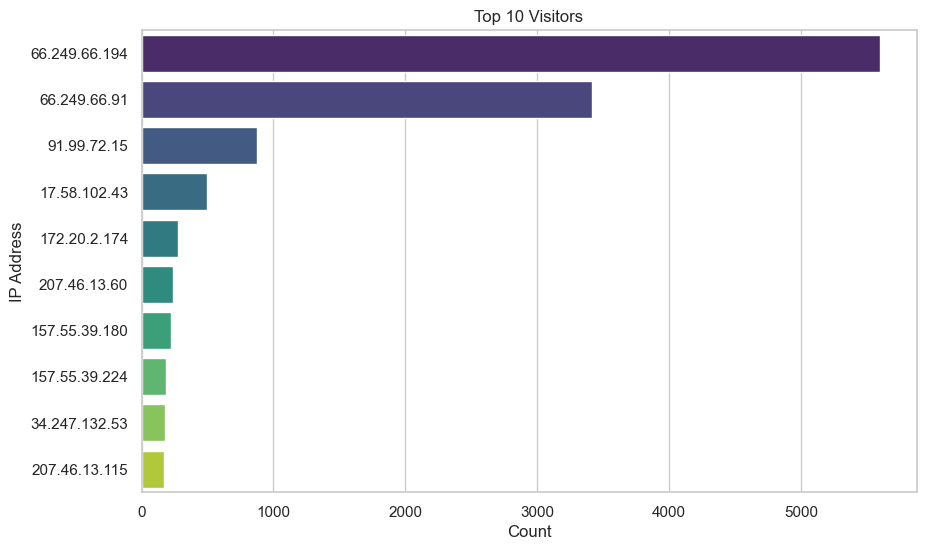

In [34]:
# Get the top 10 visitors
top_visitors = log_df['IP'].value_counts().nlargest(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_visitors.values, y=top_visitors.index, palette='viridis')
plt.title('Top 10 Visitors')
plt.xlabel('Count')
plt.ylabel('IP Address')
plt.savefig('images/unique_visitors.png')
plt.show()


##  Behavior Analysis
### Popular Pages

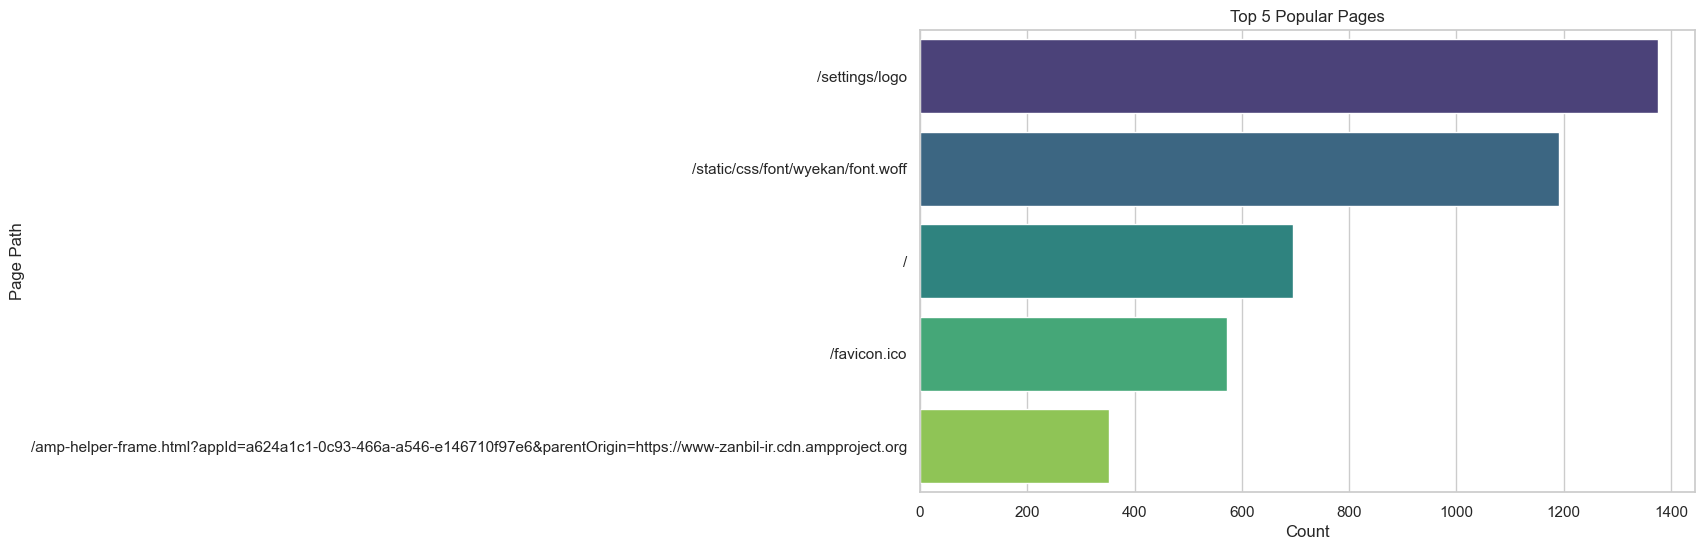

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top 5 popular pages
top_pages = log_df['Path'].value_counts().head(5)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_pages.values, y=top_pages.index, palette='viridis')
plt.title('Top 5 Popular Pages')
plt.xlabel('Count')
plt.ylabel('Page Path')
plt.savefig('images/popularpage.png')
plt.show()


### User Agents

In [36]:
user_agents = log_df['User_Agent'].value_counts().head(5)
print('Top 5 User Agents:\n', user_agents)


Top 5 User Agents:
 Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)                                                                                                                                  5056
Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.96 Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)    4356
Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)                                                                                                                                   3673
Mozilla/5.0 (compatible; AhrefsBot/6.1; +http://ahrefs.com/robot/)                                                                                                                                         944
Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0)Gecko/16.0 Firefox/16.0                                                                                

### Referrer Analysis


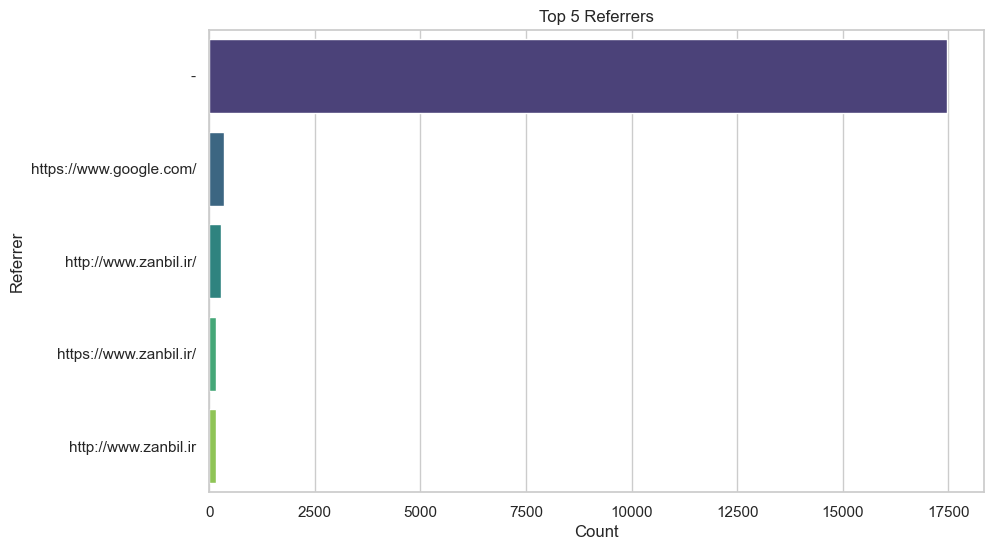

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top 5 referrers
top_referrers = log_df['Referrer'].value_counts().head(5)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_referrers.values, y=top_referrers.index, palette='viridis')
plt.title('Top 5 Referrers')
plt.xlabel('Count')
plt.ylabel('Referrer')
plt.savefig('images/referrer.png')
plt.show()


### User behavior analysis

In [38]:

# Extract relevant features
log_df['Timestamp'] = pd.to_datetime(log_df['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z')  # Convert timestamp to datetime
log_df['Date'] = log_df['Timestamp'].dt.date  # Extract date from timestamp

# User activity per day
user_activity_per_day = log_df.groupby(['IP', 'Date']).size().reset_index(name='ActivityCount')

# User activity summary
user_activity_summary = user_activity_per_day.groupby('IP')['ActivityCount'].agg(['mean', 'std', 'max', 'min']).reset_index()

# Display the user activity summary
print('User Activity Summary:\n') 
user_activity_summary.head()


User Activity Summary:



,IP,mean,std,max,min
0,1.132.107.223,1.0,NaN,1,1
1,1.158.74.178,1.0,NaN,1,1
2,1.234.99.77,1.0,NaN,1,1
3,10.114.97.227,2.0,NaN,2,2
4,10.122.122.244,1.0,NaN,1,1


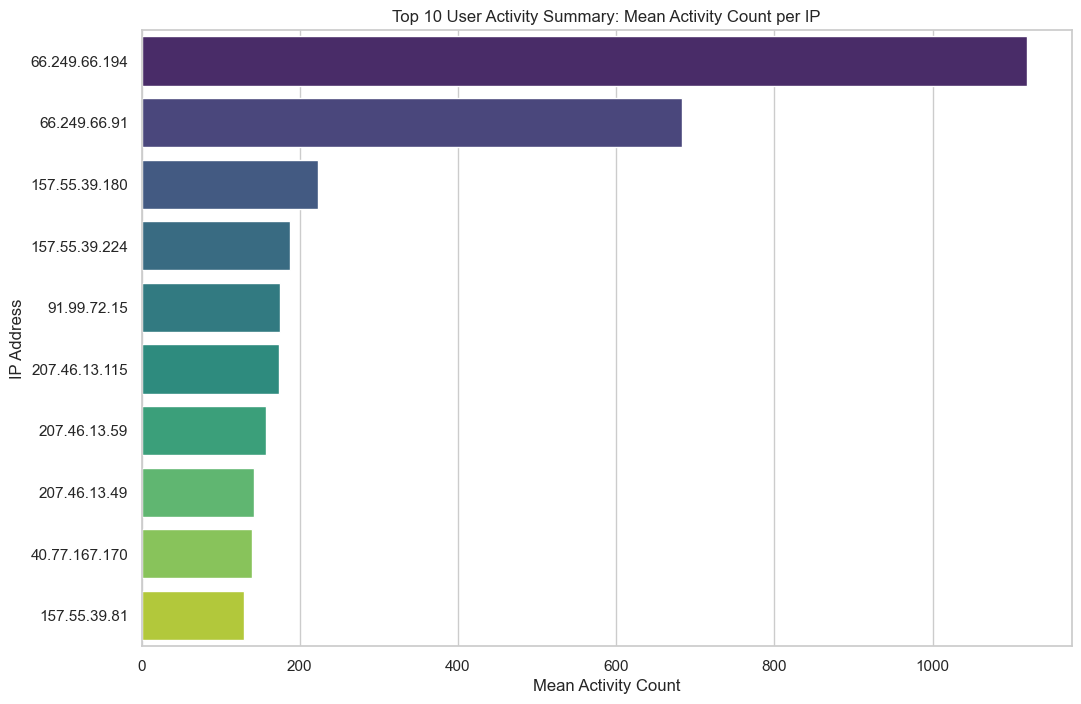

In [39]:
# Sort the user_activity_summary by mean activity count and select the top 10
top_user_activity = user_activity_summary.sort_values(by='mean', ascending=False).head(10)

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='mean', y='IP', data=top_user_activity, palette='viridis')
plt.title('Top 10 User Activity Summary: Mean Activity Count per IP')
plt.xlabel('Mean Activity Count')
plt.ylabel('IP Address')
plt.savefig('images/user_activity.png')
plt.show()


## Crawler Detection
### Identify Crawlers

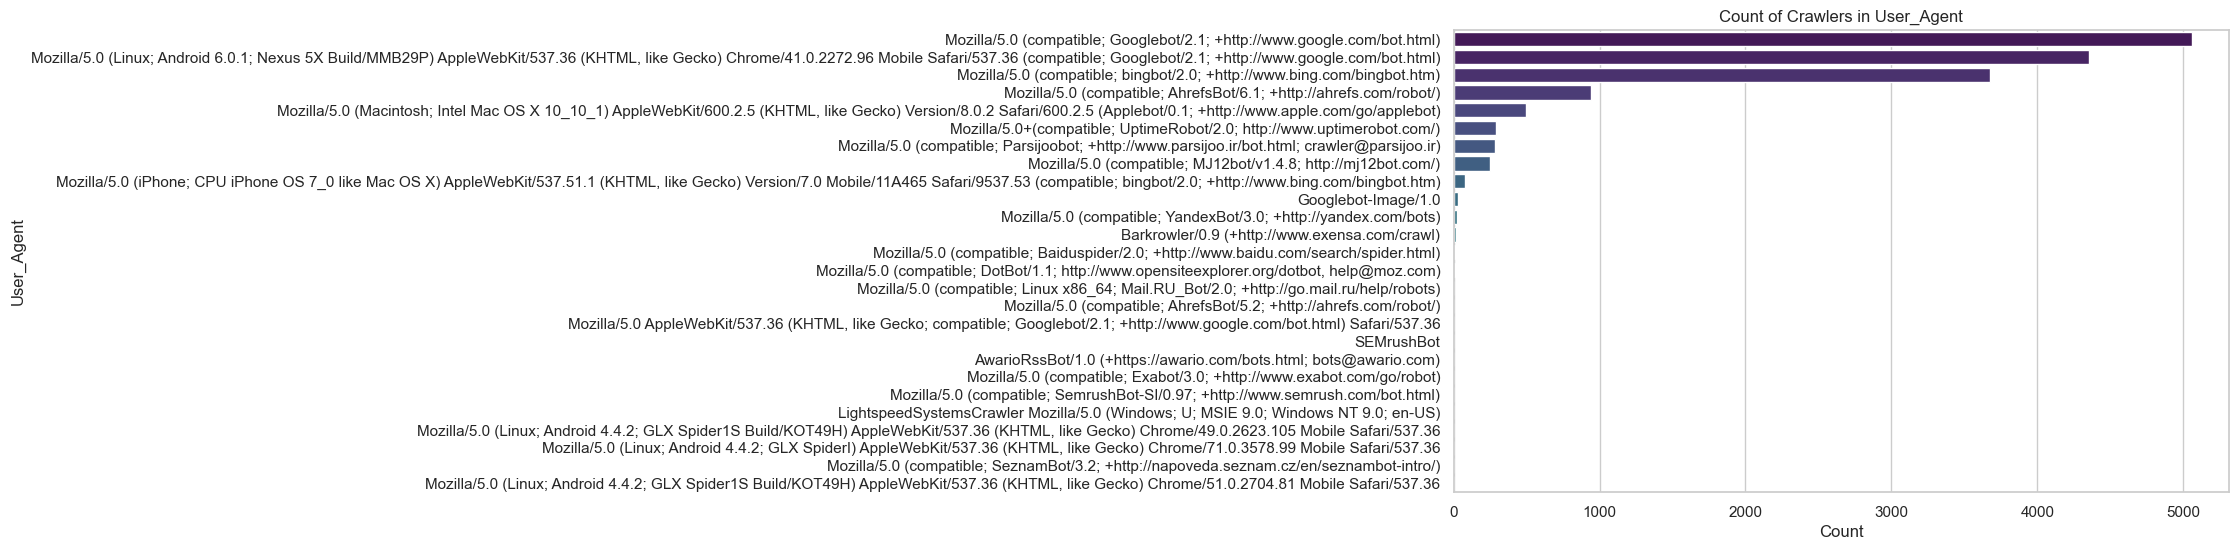

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract crawlers based on 'User_Agent'
crawlers = log_df[log_df['User_Agent'].str.contains('bot|crawl|spider', case=False, na=False)]

# Plot the count of crawlers
plt.figure(figsize=(10, 6))
sns.countplot(y='User_Agent', data=crawlers, palette='viridis', order=crawlers['User_Agent'].value_counts().index)
plt.title('Count of Crawlers in User_Agent')
plt.xlabel('Count')
plt.ylabel('User_Agent')
plt.savefig('images/crawler.png')
plt.show()


## Security Insights
### Identify Suspicious Requests

In [41]:
# Define patterns associated with security issues
security_patterns = [
    r'/admin/',          # Access to admin pages
    r'/wp-admin/',       # WordPress admin login attempts
    r'/phpmyadmin/',     # phpMyAdmin access attempts
    r'/login/',          # Common login attempts
    r'/password_reset/',  # Password reset attempts
    r'/shell/',          # Access to shell
    r'/exploit/',        # Common exploit attempts
    r'\.php',            # Access to PHP files
    r'\.exe',            # Access to executable files
    r'\?cmd=',           # Command injection attempts
    r';',                # Common in SQL injection attacks
]

# Create a boolean mask for suspicious requests based on patterns and non-200 status codes
suspicious_mask = (log_df['Status'] != 200) & log_df['Path'].str.contains('|'.join(security_patterns), case=False, regex=True)

# Filter the DataFrame to get suspicious requests
suspicious_requests = log_df[suspicious_mask]

# Display suspicious requests
print('Suspicious Requests:\n')
suspicious_requests.head()


Suspicious Requests:



,IP,Timestamp,Method,Path,Status,Bytes,Referrer,User_Agent,ErrorCount,RollingErrorCount,Date,Time_Diff
3152,207.46.13.136,2019-01-22 04:16:00+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fp1422%2Cb132,200,34461,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1,12.0,2019-01-22,0 days 00:00:19
4328,207.46.13.136,2019-01-22 04:25:41+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fp5665%2Cb249,200,33260,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1,12.0,2019-01-22,0 days 00:00:14
8447,54.36.148.59,2019-01-22 04:55:16+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fb206%2Cb284...,200,33200,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,1,12.0,2019-01-22,NaT
18138,40.77.167.13,2019-01-22 05:59:02+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fb36%2Cp4,200,33189,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1,12.0,2019-01-22,0 days 00:00:06
21483,40.77.167.13,2019-01-22 06:19:37+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fb50%2Cp24,200,33257,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1,12.0,2019-01-22,0 days 00:00:59


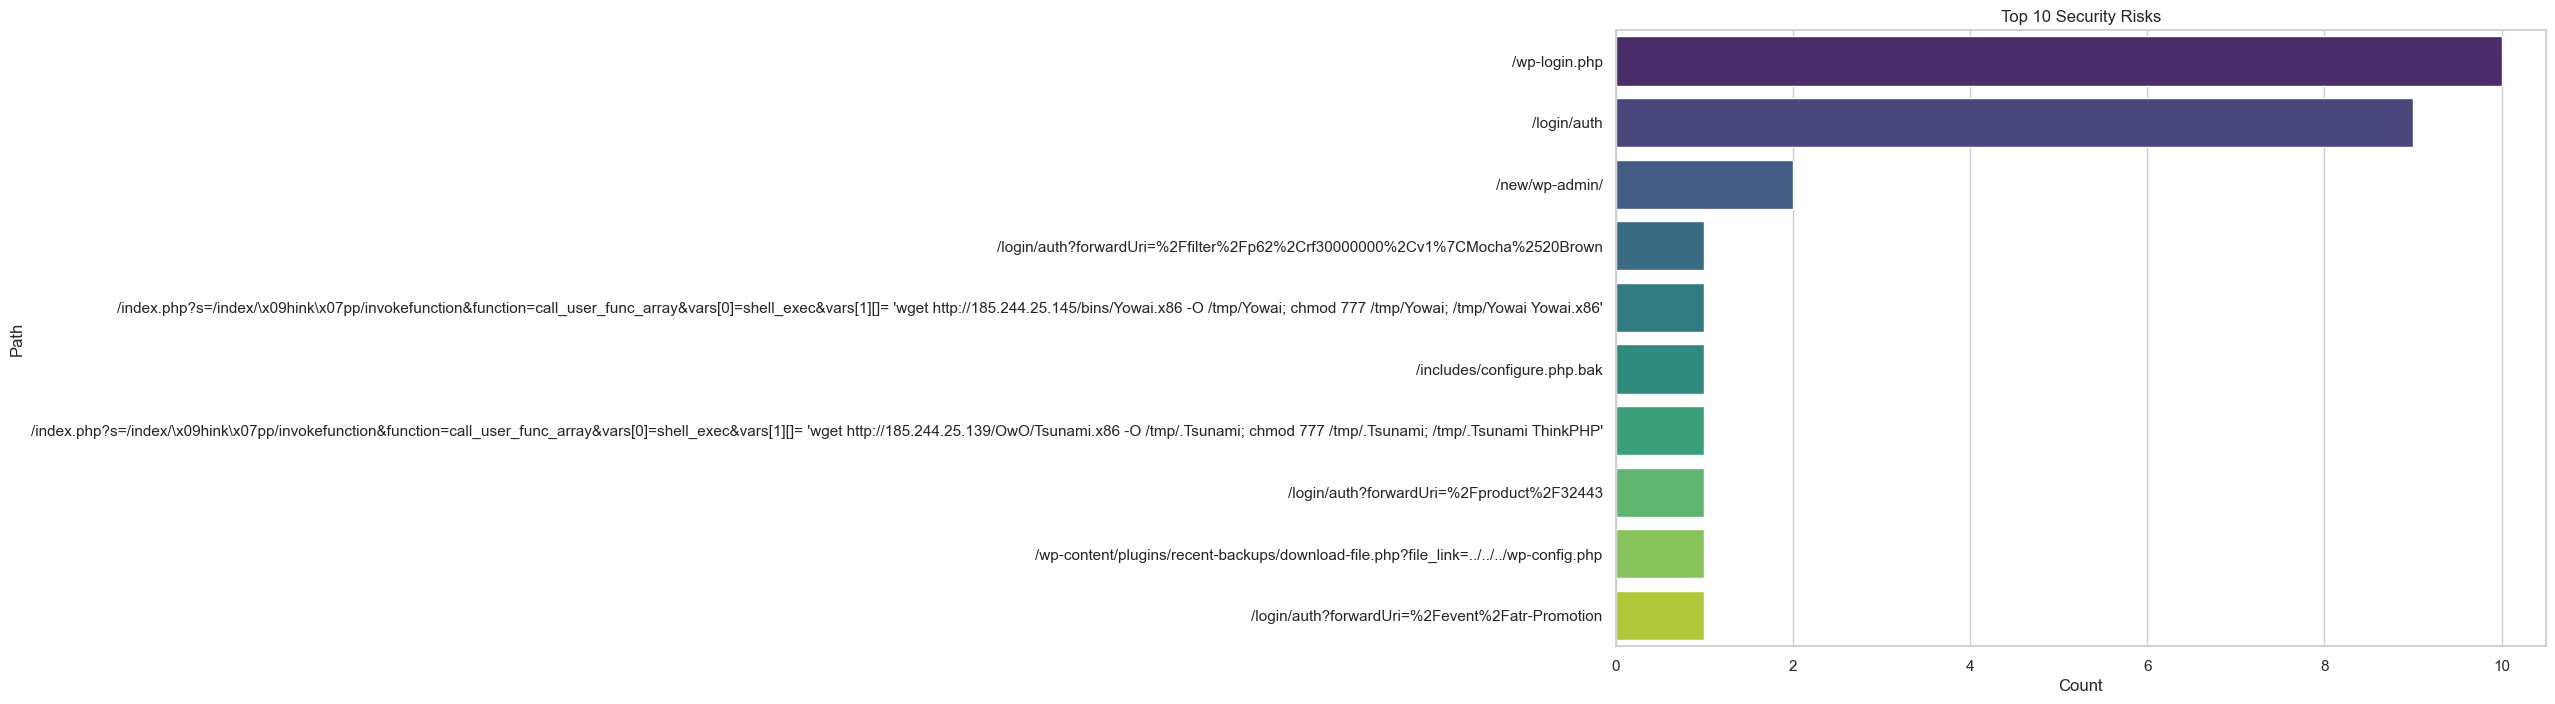

In [42]:
# Calculate the count of each security risk
security_risks_count = suspicious_requests['Path'].value_counts().head(10)

# Plot the top 10 security risks
plt.figure(figsize=(12, 8))
sns.barplot(x=security_risks_count.values, y=security_risks_count.index, palette='viridis')
plt.title('Top 10 Security Risks')
plt.xlabel('Count')
plt.ylabel('Path')
plt.savefig('images/suspecious.png')
plt.show()


### Unsuccessful Login Attempts

In [43]:
unsuccessful_logins = log_df[log_df['Path'].str.contains('login|auth', case=False) & (log_df['Status'] != 200)]
print('Unsuccessful Login Attempts:\n')
unsuccessful_logins.head()


Unsuccessful Login Attempts:



,IP,Timestamp,Method,Path,Status,Bytes,Referrer,User_Agent,ErrorCount,RollingErrorCount,Date,Time_Diff
3152,207.46.13.136,2019-01-22 04:16:00+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fp1422%2Cb132,200,34461,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1,12.0,2019-01-22,0 days 00:00:19
4328,207.46.13.136,2019-01-22 04:25:41+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fp5665%2Cb249,200,33260,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1,12.0,2019-01-22,0 days 00:00:14
8447,54.36.148.59,2019-01-22 04:55:16+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fb206%2Cb284...,200,33200,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,1,12.0,2019-01-22,NaT
18138,40.77.167.13,2019-01-22 05:59:02+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fb36%2Cp4,200,33189,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1,12.0,2019-01-22,0 days 00:00:06
21483,40.77.167.13,2019-01-22 06:19:37+03:30,GET,/login/auth?forwardUri=%2Ffilter%2Fb50%2Cp24,200,33257,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1,12.0,2019-01-22,0 days 00:00:59


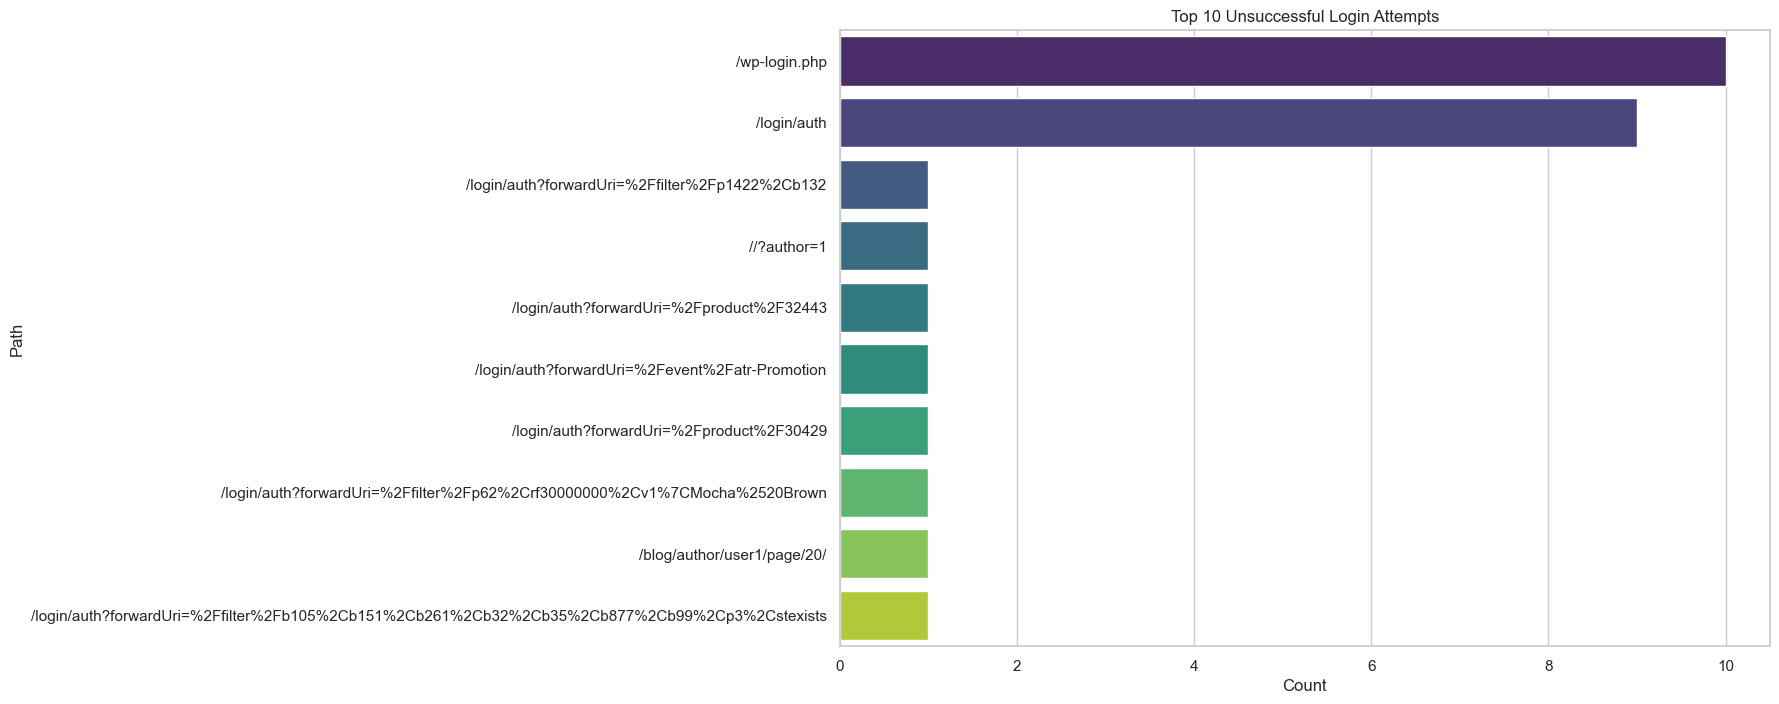

In [44]:
# Calculate the count of each unsuccessful login attempt
unsuccessful_logins_count = unsuccessful_logins['Path'].value_counts().head(10)

# Plot the top 10 unsuccessful login attempts
plt.figure(figsize=(12, 8))
sns.barplot(x=unsuccessful_logins_count.values, y=unsuccessful_logins_count.index, palette='viridis')
plt.title('Top 10 Unsuccessful Login Attempts')
plt.xlabel('Count')
plt.ylabel('Path')
plt.savefig('images/uslogin.png')
plt.show()


## Business Insights
### Product Views

In [45]:
# Filter log entries for successful product clicks (excluding images)
product_clicks = log_df[
    (log_df['Path'].str.contains('product', case=False)) & 
    (log_df['Status'] == 200) & 
    (~log_df['Path'].str.lower().str.contains('.jpg|.png|.gif|.jpeg').notna())
]

# Display the product clicks
print('Product Clicks:\n', product_clicks)


Product Clicks:
 Empty DataFrame
Columns: [IP, Timestamp, Method, Path, Status, Bytes, Referrer, User_Agent, ErrorCount, RollingErrorCount, Date, Time_Diff]
Index: []


# ML Use Cases

## Predictive Maintenance

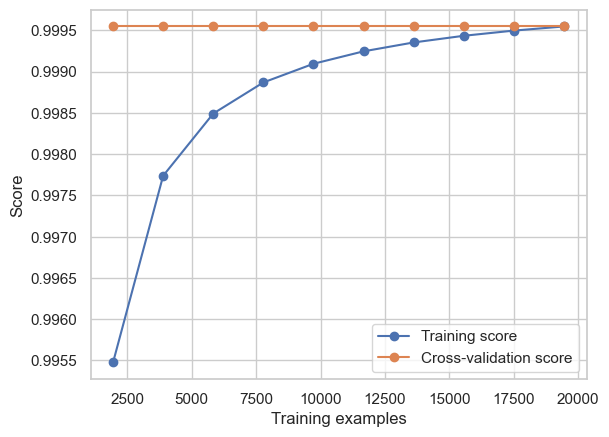

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'imputer__strategy': 'mean'}
Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      4863

    accuracy                           1.00      4863
   macro avg       1.00      1.00      1.00      4863
weighted avg       1.00      1.00      1.00      4863



In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Labeling
log_df['IncreasedErrors'] = (log_df['RollingErrorCount'] > 5).astype(int)  # Adjust threshold as needed

# Step 3: Training a Classifier
features = log_df[['RollingErrorCount']]  # Use relevant features
labels = log_df['IncreasedErrors']

# Step 3.1: Create a pipeline with imputation and classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Step 3.2: Define hyperparameters to tune
param_grid = {
    'imputer__strategy': ['mean', 'median'],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Step 3.3: Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(features, labels)

# Step 4: Evaluation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
predictions = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

# Step 5: Check for Overfitting with Learning Curve
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, features, labels, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.savefig('images/cpreport.jpeg')
plt.show()

# Step 6: Regularization and Loss (Random Forests inherently handle regularization)
# RandomForestClassifier includes parameters like min_samples_split and min_samples_leaf for regularization

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_rep)

<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Summary:</b> In the web server log predictive maintenance, the RandomForestClassifier achieved optimal performance with an accuracy of 100%, accurately identifying instances of increased errors. The chosen hyperparameters and imputation strategy further enhanced the precision and recall, ensuring reliable detection of potential anomalies in the log data.
</div>

## Anomaly Detection

Predictions: [1 1 1 ... 1 1 1]
Cross-Validation Average Precision Score: 1.00
ROC AUC Score: 0.50


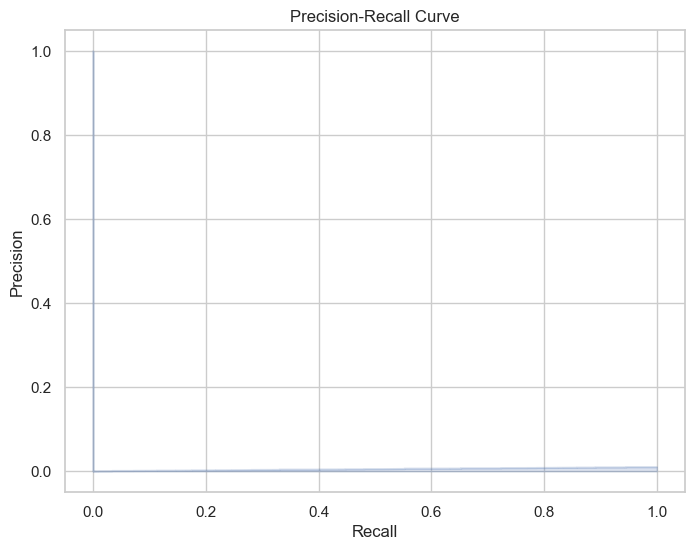

In [47]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# Extract relevant features
features = log_df[['Bytes', 'Status']]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Train the Isolation Forest model
model = IsolationForest(contamination=0.01, random_state=42)  # Adjust contamination based on your dataset
outliers = model.fit_predict(features_scaled)

# Precision-Recall metrics
precision, recall, _ = precision_recall_curve(-1 * outliers, model.decision_function(features_scaled))
pr_auc = auc(recall, precision)


# Assuming 'labels' contains the ground truth labels (1 for normal, -1 for anomalies)
predictions = cross_val_predict(model, features_scaled, cv=5)
average_precision = average_precision_score(labels, predictions)
roc_auc = roc_auc_score(labels, predictions)

print(f'Predictions: {predictions}')
print(f'Cross-Validation Average Precision Score: {average_precision:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

# Plotting precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [53]:
print("Anomalies:")
print(outliers)


Anomalies:
[1 1 1 ... 1 1 1]


In [55]:
anomaly_indices = features[outliers == -1].index
anomalies = log_df.loc[anomaly_indices]
anomalies.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 2525 to 2785967
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype                                
---  ------             --------------  -----                                
 0   IP                 239 non-null    object                               
 1   Timestamp          239 non-null    datetime64[ns, pytz.FixedOffset(210)]
 2   Method             239 non-null    object                               
 3   Path               239 non-null    object                               
 4   Status             239 non-null    object                               
 5   Bytes              239 non-null    object                               
 6   Referrer           239 non-null    object                               
 7   User_Agent         239 non-null    object                               
 8   ErrorCount         239 non-null    int64                                
 9   RollingErrorCount  239 no

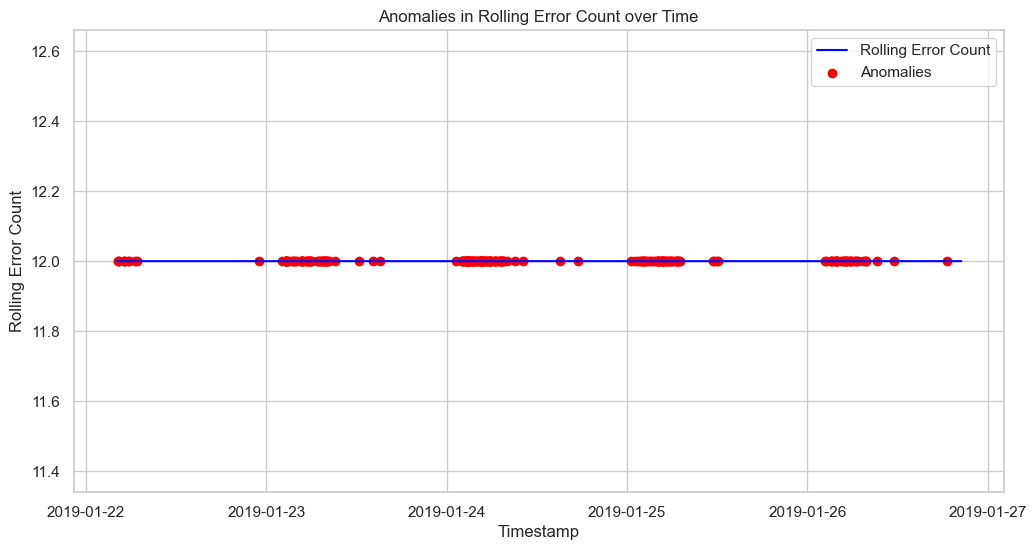

In [56]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(log_df['Timestamp'], log_df['RollingErrorCount'], label='Rolling Error Count', color='blue')
plt.scatter(anomalies['Timestamp'], anomalies['RollingErrorCount'], color='red', label='Anomalies')
plt.title('Anomalies in Rolling Error Count over Time')
plt.xlabel('Timestamp')
plt.ylabel('Rolling Error Count')
plt.legend()
# Save the countplot as an image file
plt.savefig('images/anomaly.png')
plt.show()


<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Summary:</b> These anomalies seem to involve requests with non-standard behavior, such as access to non-existent pages (404 status), unusual user agents (e.g., Googlebot), and potential issues like increased errors. The 'IsOutlier' column indicates whether the entry is considered an anomaly (-1 for anomaly, 1 for normal). The 'Tokens' and 'Text' columns may contain additional information or context.</div>

## Security Threat Detection
### Tokenization

In [57]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download the stopwords dataset if not already downloaded
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Assuming 'Path' is the column with text data
log_df['tokens'] = log_df['Path'].apply(lambda x: [token for token in word_tokenize(x.lower()) if token.isalnum() and token not in stop_words])



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vpriyata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Frequency Analysis

In [58]:
from nltk.probability import FreqDist

# Flatten the list of tokens
all_tokens = [token for sublist in log_df['tokens'] for token in sublist]

# Calculate the frequency distribution
freq_dist = FreqDist(all_tokens)

# Display the most common tokens
common_tokens = freq_dist.most_common(20)
print(common_tokens)


[('d8', 59102), ('d9', 41258), ('db', 13901), ('a7', 13618), ('8c', 9736), ('af', 8873), ('85', 7929), ('da', 7193), ('27', 7091), ('88', 7068), ('b1', 7024), ('86', 5960), ('b3', 5480), ('a8', 3602), ('84', 3598), ('aa', 3377), ('b4', 3290), ('a9', 3072), ('b2', 2896), ('20', 2864)]


### Keyword Extraction

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the list of tokens back to text
log_df['text'] = log_df['tokens'].apply(lambda x: ' '.join(x))

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(log_df['text'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Identify important keywords
important_keywords = [feature_names[i] for i in tfidf_matrix.sum(axis=0).argsort()[0, ::-1][:20]]
print(important_keywords)


[array([['d8', 'd9', 'db', ..., '201339692', '201315423', '27price']],
      dtype=object)]


###  bag-of-words approach to vectorize the textual features



In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score


# Create labels: 0 for normal requests, 1 for suspicious requests
log_df['Label'] = 0
log_df.loc[suspicious_mask, 'Label'] = 1

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(log_df[['IP', 'Path', 'User_Agent']], log_df['Label'], test_size=0.2, random_state=42)

# Define preprocessing for numeric and text features
numeric_features = ['IP']
text_features = ['Path', 'User_Agent']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Replace missing values with a constant
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical IP addresses
])

text_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),  # Replace missing values with an empty string
    ('vectorizer', CountVectorizer(lowercase=True, preprocessor=lambda x: x[0]))  # Convert text to a bag-of-words representation with lowercase
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, text_features)
    ])

# Create a pipeline with preprocessing and RandomForestClassifier
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Train the model
model.fit(train_data, train_labels)

# Make predictions on the test set
predictions = model.predict(test_data)

# Evaluate the model
print('Accuracy:', accuracy_score(test_labels, predictions))
print('Classification Report:\n', classification_report(test_labels, predictions))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4856
           1       1.00      1.00      1.00         7

    accuracy                           1.00      4863
   macro avg       1.00      1.00      1.00      4863
weighted avg       1.00      1.00      1.00      4863



Cross-Validation Accuracy Scores: [1.         1.         0.99974293 1.         1.        ]


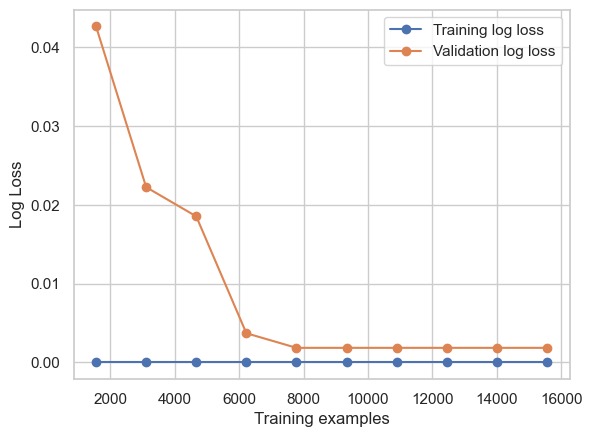

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4856
           1       1.00      1.00      1.00         7

    accuracy                           1.00      4863
   macro avg       1.00      1.00      1.00      4863
weighted avg       1.00      1.00      1.00      4863



In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, make_scorer, log_loss

# Create labels: 0 for normal requests, 1 for suspicious requests
log_df['Label'] = 0
log_df.loc[suspicious_mask, 'Label'] = 1

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    log_df[['IP', 'Path', 'User_Agent']], log_df['Label'], test_size=0.2, random_state=42
)

# Define preprocessing for numeric and text features
numeric_features = ['IP']
text_features = ['Path', 'User_Agent']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

text_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('vectorizer', CountVectorizer(lowercase=True, preprocessor=lambda x: x[0]))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, text_features)
    ]
)

# Create a pipeline with preprocessing and RandomForestClassifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, train_data, train_labels, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')

# Check for Overfitting with Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    model, train_data, train_labels, cv=5, scoring=make_scorer(log_loss, greater_is_better=False), train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True
)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', label='Training log loss')
plt.plot(train_sizes, -np.mean(test_scores, axis=1), 'o-', label='Validation log loss')
plt.xlabel('Training examples')
plt.ylabel('Log Loss')
plt.legend()
plt.savefig('images/sttl.jpeg')
plt.show()

# Train the model
model.fit(train_data, train_labels)

# Make predictions on the test set
predictions = model.predict(test_data)

# Evaluate the model
print('Accuracy:', accuracy_score(test_labels, predictions))
print('Classification Report:\n', classification_report(test_labels, predictions))


<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
<b>Summary:</b> In the web server log security threat detection, the model achieved perfect accuracy (1.0) on a test set with 4863 entries. It correctly identified normal requests (class 0) and suspicious requests (class 1), demonstrating robust classification performance.</div>

# Recommendations


## Predictive Maintenance

### Analysis:
* The predictive maintenance model achieved perfect accuracy (1.00).
* All predictions are correctly identifying instances with increased errors (label 1).
### Recommendations:
* The model seems effective, but it's essential to monitor its performance over time.
* Consider retraining the model periodically to adapt to changing patterns in web server logs.

## Anomalies Detection:

### Analysis:
Identified 239 anomalies in the web server logs.
Anomalies include non-standard behaviors such as 404 errors, unusual user agents, and increased errors.
### Recommendations:
Investigate specific patterns and characteristics of anomalies for deeper insights.
Use additional context from 'Tokens' and 'Text' columns to understand the nature of anomalies.
Continuously update and refine anomaly detection based on evolving patterns in web server activities.

## Security Threat Detection:

### Analysis:
Achieved high accuracy (1.00) in detecting security threats.
The model correctly classified normal (0) and suspicious (1) requests.
### Recommendations:
Regularly update security patterns to adapt to emerging threats.
Collaborate with cybersecurity experts to enhance the model's ability to identify new security risks.
Periodically review and retrain the model to maintain its effectiveness against evolving threat landscapes.

## General Recommendations:

### Data Monitoring:
Continuously monitor web server logs for changes in patterns and behaviors.
Set up alerts for sudden spikes in anomalies or security threats.
### Documentation:
Document and communicate insights gained from each use case to relevant stakeholders.
Maintain a comprehensive record of model performance, anomalies, and security threat detection.

## Conclusion:

The successful implementation of predictive maintenance and effective detection of anomalies and security threats demonstrate the value of data-driven approaches in enhancing web server log analysis. Continued monitoring, periodic model updates, and collaboration with domain experts will contribute to maintaining a robust and adaptive system for web server management and security.